In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

In [3]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors


In [4]:
def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None):

    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()

def plt_show_gray (image):

    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):

    plt.figure ()
    plt.imshow (image)
    plt.show ()

In [5]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non-' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(len(cars))
print(len(notcars))

8792
8968


In [6]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

visualizing HOG features


C:\Users\vinaykas\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


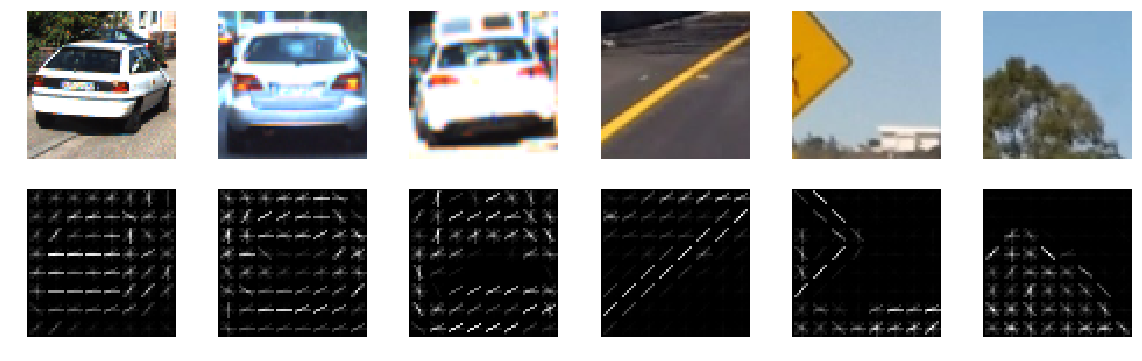

In [7]:
# Reading Test images to visualize HOG features
images_to_visualize=glob.glob('test_img/*')
feature_imgs =[]
feature_examples = []
for img in images_to_visualize:
    i = cv2.imread(img)
    i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
    feature_imgs.append(i)
feature_examples.extend(feature_imgs)

for img_sample in feature_imgs:
    ip_sample = img_sample
    ip_sample = cv2.cvtColor(ip_sample,cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(ip_sample, orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
print('visualizing HOG features')    
show_images_in_table (feature_examples, (6, 2), fig_size=(20, 6))    

In [8]:


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)



C:\Users\vinaykas\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car samples:  17584
Notcar samples:  17936


In [9]:
print('Training Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC


Training Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
12.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


In [10]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC


Test Accuracy of SVC =  0.9899


In [11]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [13]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

C:\Users\vinaykas\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


11
0
0
8
4
8
6.39 Seconds to process test images


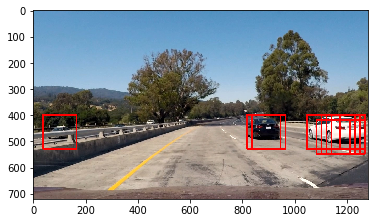

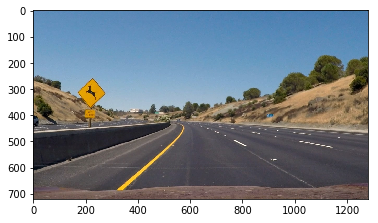

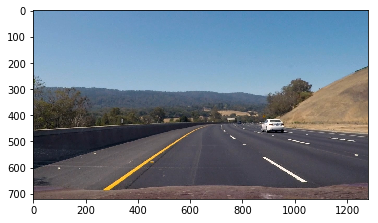

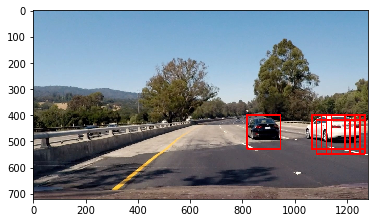

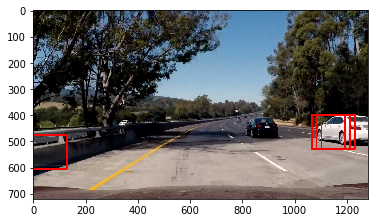

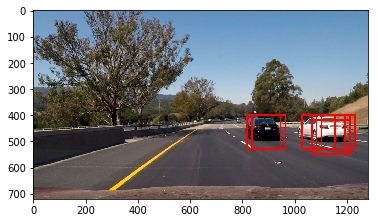

In [14]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)) 
    print(len(hot_windows))
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')


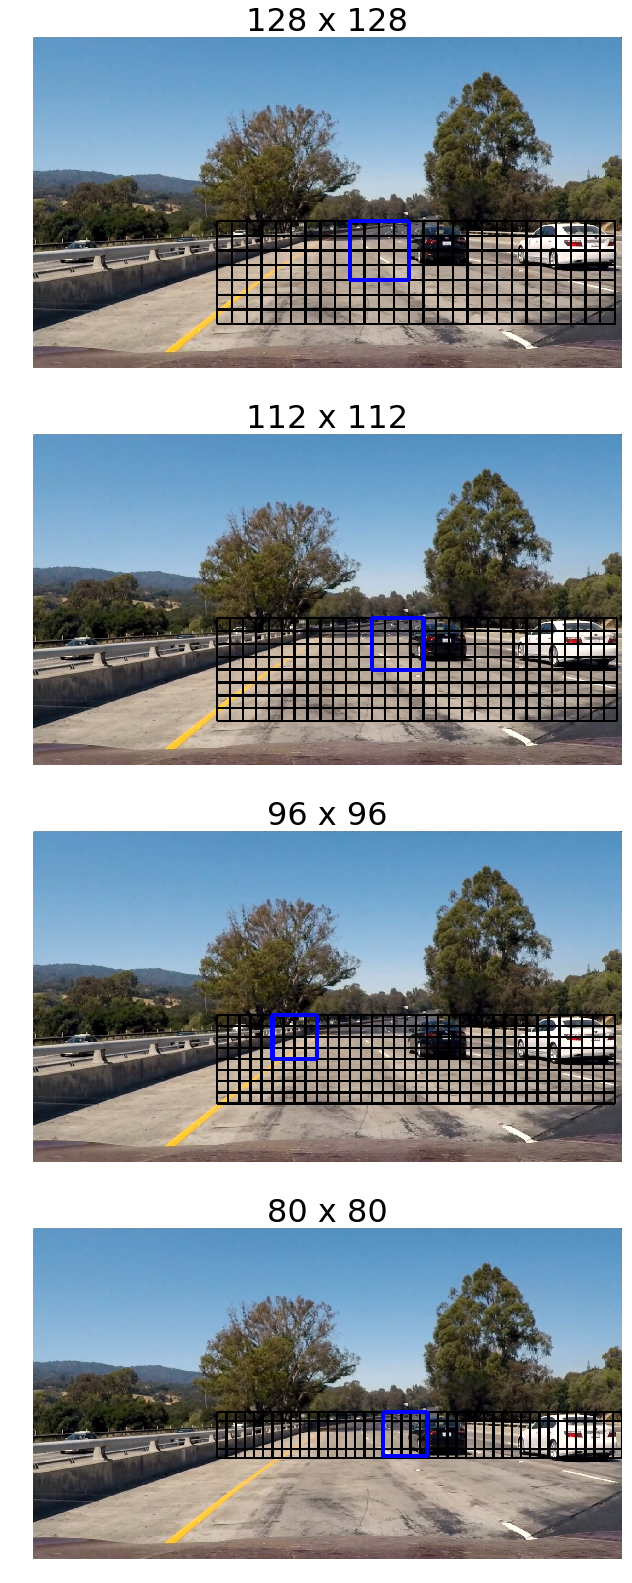

In [15]:
# defining parameters of sliding windows
image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [400, None],
    [400, None],
    [400, None],
    [400, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 640],
    [400, 600],
    [400, 500]
]

sw_window_size = [
    (128, 128),
    (112,112),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.75, 0.75),
    (0.75, 0.75),
    (0.75, 0.75),
    (0.75, 0.75)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

windows4 = slide_window(image, x_start_stop=sw_x_limits[3], y_start_stop=sw_y_limits[3], 
                    xy_window=sw_window_size[3], xy_overlap=sw_overlap[3])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows4, color=(0, 0, 0), thick=4))


# visualizing sliding windows
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)
sliding_windows [3] = draw_boxes (sliding_windows [3], [windows3[15]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128',
    '112 x 112',
    '96 x 96',
    '80 x 80'
]

show_images_in_table (sliding_windows, (1, 4), fig_size=(40, 28), titles=sw_titles)

In [16]:
def get_hot_boxes (image):


    dst = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(dst,x_start_stop=x_limits,y_start_stop=y_limits,xy_window=window_size,xy_overlap=overlap)
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend (hot_windows)

        dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst
        
def get_heat_map(image, bbox_list):


    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

class AverageHotBox ():

    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
        return self.detected_count
    
    def get_box (self):

        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):

        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.2 * area1 or
            intersection >= 0.2 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
       
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes

C:\Users\vinaykas\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


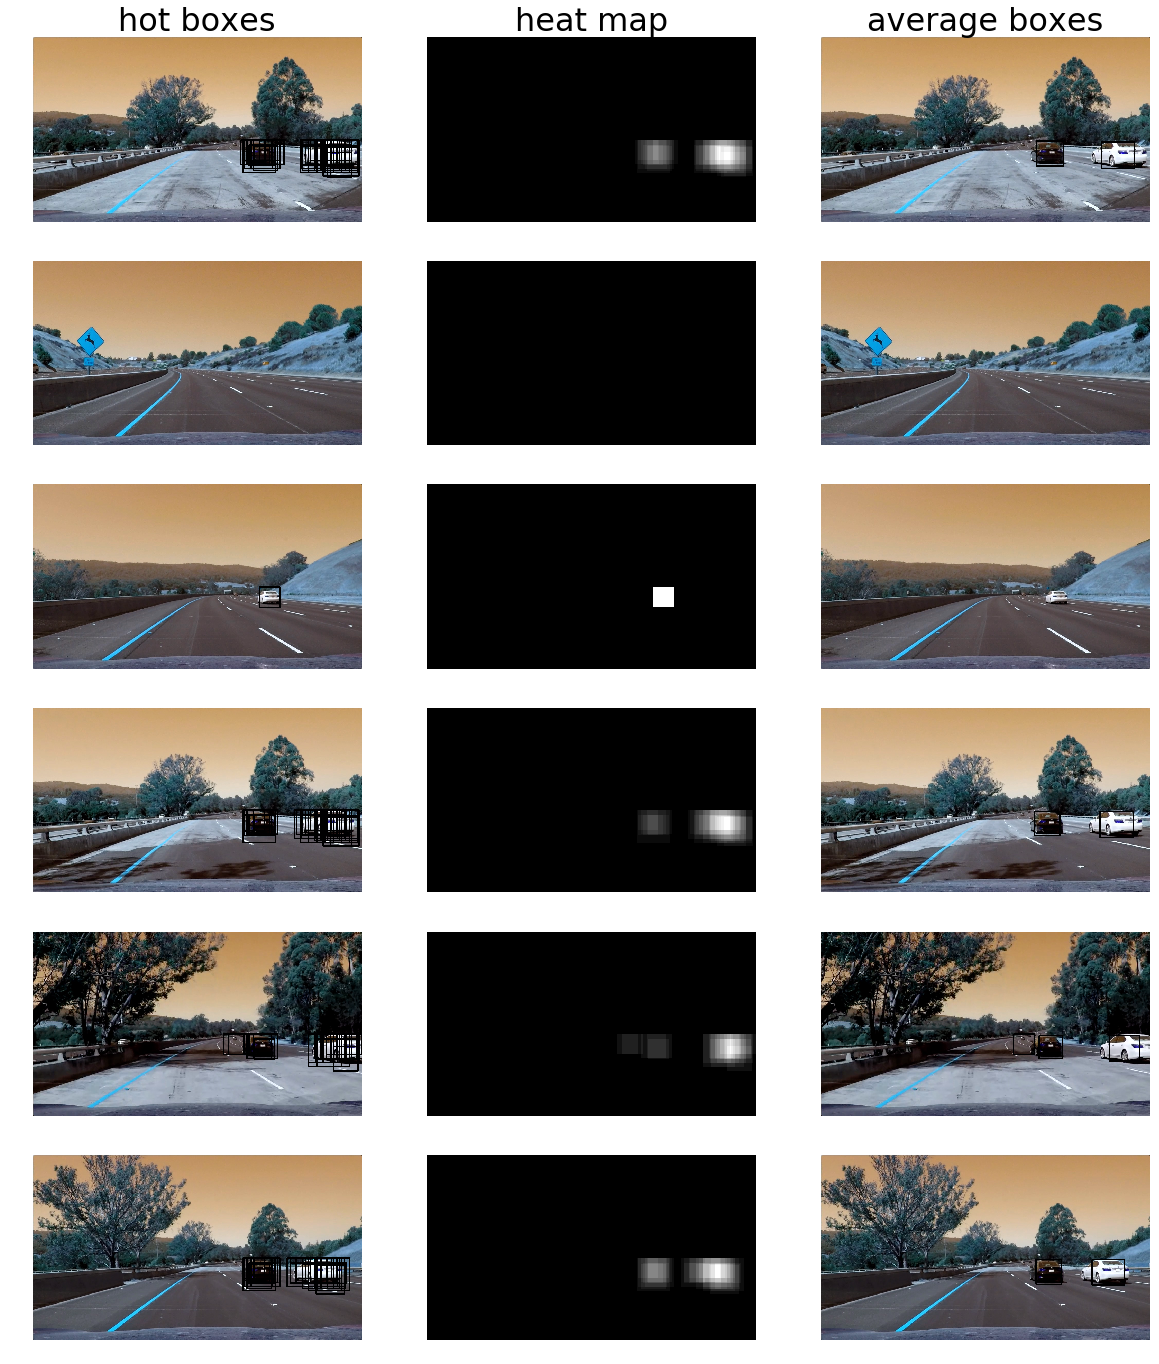

In [17]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(impath)
    

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_in_table (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [21]:
class HotBoxesHistory ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 6 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        return_boxes = []
        for boxes in self.last_boxes:
            return_boxes.extend (boxes)
        return return_boxes

old_hot_boxes = HotBoxesHistory ()

C:\Users\vinaykas\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


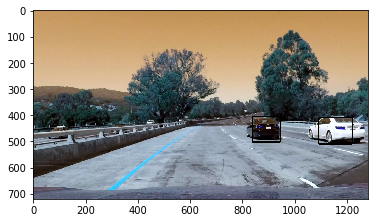

In [19]:
def process_image (image_orig):
    
    image_orig = np.copy (image_orig)
    image = cv2.cvtColor(image_orig, cv2.COLOR_RGB2BGR)
    
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    old_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = old_hot_boxes.get_hot_boxes ()
        
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image_orig, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes

image = (cv2.imread('test_images/test1.jpg'))
image = process_image(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
show_img(image)

In [ ]:
from moviepy.editor import VideoFileClip


def process_show(image):
    image_out = process_image(image)
    return image_out


output_v = 'final_video_resubmit2.mp4'
clip2 = VideoFileClip("project_video.mp4")
clip = clip2.fl_image(process_show)
%time clip.write_videofile(output_v, audio=False)
    
    


[MoviePy] >>>> Building video final_video_resubmit2.mp4
[MoviePy] Writing video final_video_resubmit2.mp4


 40%|███████████████████████████████▊                                               | 507/1261 [08:15<12:29,  1.01it/s]